SImple code for the propagation of the electric field
Assume that the E field is simply given by a real image and propagate it by
the Angular spectrum method

512 512


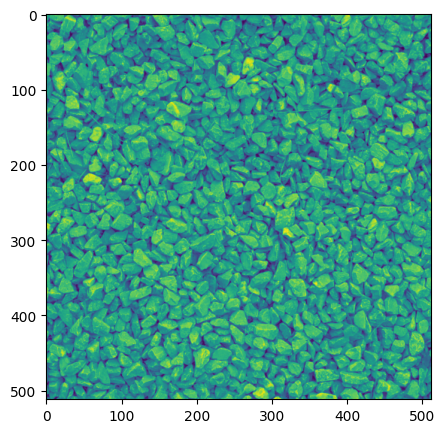

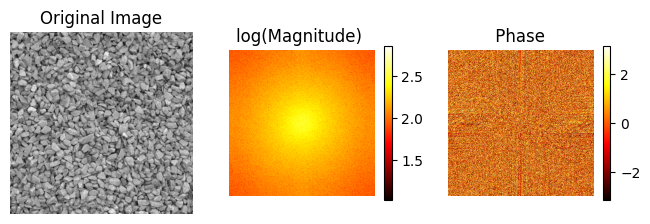

In [1]:
'''
March 2025
Giberto Chirico

This loads a sample image (whatever), RGB and comnvert it in gray scale,
then perform the FFT in 2D.

This is thought to be in colab.
to load an image, first load the image in the "content" folder on colab.
then copy the exacgtf path of the file (right click -> copy path)
Use FLAG = 'gravel'  # or 'gravel
'''

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.color import rgb2gray

# Load a sample image
FLAG = 'gravel'  # or 'gravel

if FLAG == 'cat':
  cat     = data.chelsea()
  image = rgb2gray(cat)
elif FLAG == 'gravel':
  image   = data.gravel()
else:
  print ('choose a different image')

plt.figure(figsize=(8, 5))
plt.imshow(image)

### assign a physical pixel size:
upix  = 0.3 ## um
Npix  = np.min(image.shape[0])
print (Npix, image.shape[0])
# Convert image to numpy array
image_array = np.array(image)[0:Npix,0:Npix]

# Perform FFT
fft_result  = np.fft.fft2(image_array)
fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency components to the center
Efft2       = fft_shifted                  # this is used for the propagation
######### THIS IS AN ESSENTIAL STEP
######### now compute the frequencies
frequenze           = np.fft.fftshift(np.fft.fftfreq(Npix,upix))   ######SHIFTED !!!!!

freq2x,freq2y       = np.meshgrid(frequenze,frequenze)       # also these are shifted

# Calculate magnitude spectrum
magnitude_spectrum = np.log(np.abs(fft_shifted) + 0.1)  # Add 1 to avoid log(0)
phase_spectrum     = np.angle(fft_shifted)
# Plot the results
plt.figure(figsize=(8, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image_array, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Magnitude Spectrum
plt.subplot(1, 3, 2)
plt.imshow(np.log(magnitude_spectrum), cmap='hot')
plt.title('log(Magnitude) ')
plt.colorbar(shrink = 0.4)
plt.axis('off')

# Phase Spectrum
plt.subplot(1, 3, 3)
plt.imshow(phase_spectrum, cmap='hot')
plt.title(' Phase ')
plt.colorbar(shrink = 0.4)
plt.axis('off')
plt.show()


k0= 9.894780011306436  at 511


Text(0.5, 1.0, 'propagated to 2')

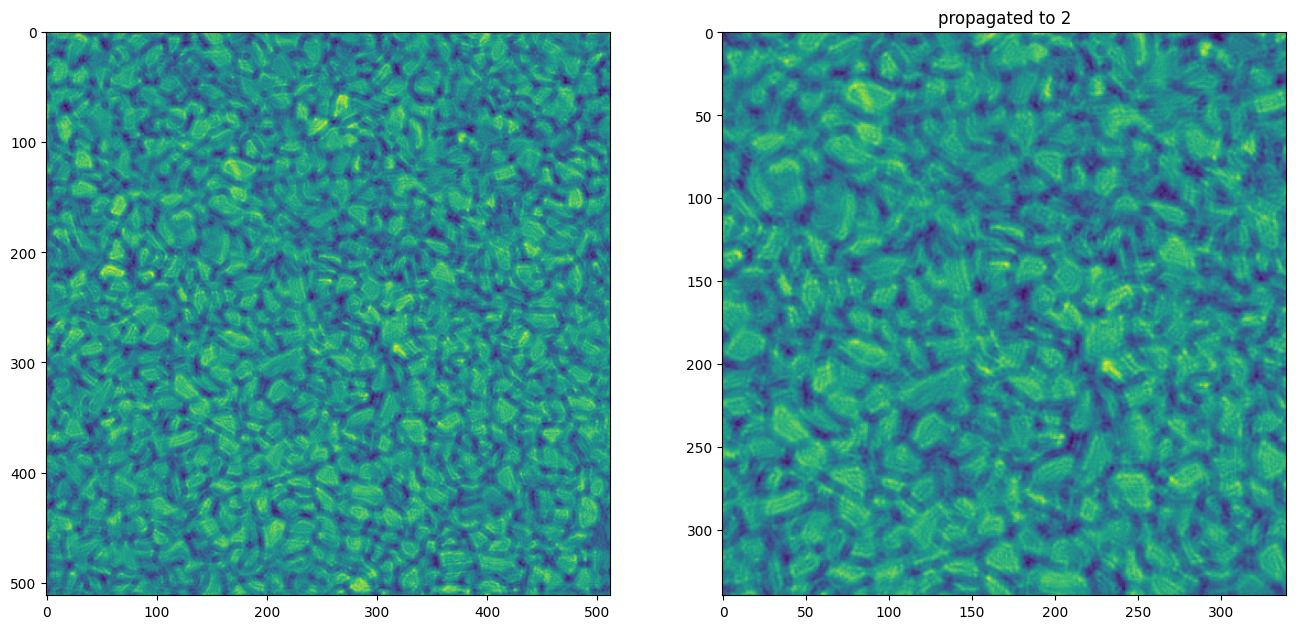

In [6]:
########### define the Fourier Kernel for the propagation
############## this is the routine to propagate the image

def FresnelKernel(k0,Freqx,Freqy,z):
  F2 = Freqx**2 + Freqy**2
  KF = np.zeros(F2.shape,dtype = 'complex')

  KF = np.exp( -1j * np.sqrt(np.abs(k0*k0-4*np.pi*np.pi*F2))*z)

  # Create a circular mask of radius = k0
  rows, cols = KF.shape
  center_row, center_col = rows // 2, cols // 2
  radius = 30  # Adjust the radius as needed
#### implement the mask for spatial frequencies above k0/2pi
  for index, value in enumerate(Freqx[0,:]):
        if value > k0/2/np.pi:
            radius = index
  print ('k0=',k0,' at',index)
  Y, X = np.ogrid[:rows, :cols]
  mask = (X - center_col)**2 + (Y - center_row)**2 <= radius**2

  # Apply the mask to the FFT spectrum
  masked_KF = KF * mask
  return masked_KF

############# propagation at z
wav   = 0.635
k0    = 2*np.pi/0.635 ### lambda = 635 nm
z     = 2  ###um

masked_KF = FresnelKernel(k0,freq2x,freq2y,z)   ## propagation kernel, notice the freq are shifted - so "human"
Eprop_z   = np.fft.fft2(np.fft.fftshift(Efft2 * masked_KF))  ## propagation

Eprop_z   = np.fliplr(np.flipud(Eprop_z))

Magz      = np.abs(Eprop_z)
plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.imshow(Magz)

plt.subplot(1,2,2)
plt.imshow(Magz[Npix//2 - Npix//3:Npix//2 + Npix//3,Npix//2 - Npix//3:Npix//2 + Npix//3])
plt.title('propagated to '+str(z))